# Case studies

This notebooks contains codes to study the relationship between blink parameters captured with BlinkWise and mental states (drowsiness and cognitive load).

It also checks the partial blink detection, which is related to ocular health (i.e., dye eye disease).

Results reproduced:
1. tab 4: Correlations between Drowsiness Measures and Blink Parameters
2. fig 14: Drowsiness evaluation over 12 hours.
3. tab 5: Blink Parameter Variations Across Visual Task Difficulty Levels
4. fig 15: Blink parameters across different workloads. Abbreviations are the same as in Tab. 5.
5. fig 16: Partial blink detection.

## imports and global utilities

In [1]:
%matplotlib inline

import itertools
from pathlib import Path

from prettytable import PrettyTable
from scipy import stats

import pingouin as pg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def p_value_to_significance(p_value):
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    elif p_value < 0.1:
        return "†"
    else:
        return "n.s."

## blinks and drowsiness 

In [3]:
drowsiness_blink_parameters_file = Path("../data/case-studies/drowsiness_blink_parameters.csv")
drowsiness_blink_parameters_df = pd.read_csv(drowsiness_blink_parameters_file)
drowsiness_blink_parameters_df.head()

,subject_id,session,n_blinks,n_non_blinks,closing_time_mean,closing_time_std,closing_time_median,closed_time_mean,closed_time_std,closed_time_median,...,open_time_std,open_time_median,n_pvt_measurements,pvt_mean,pvt_std,pvt_median,pvt_lapses,pvt_fast10p,pvt_slowest10p,kss_score
0,1,1,263,262,108.876934,25.250822,108.898878,77.227288,53.099957,67.777157,...,743.007507,631.138682,54,630.722222,392.911328,493.0,26,425.0,1610.2,8
1,1,2,322,321,110.313710,15.342654,110.004067,63.404787,26.241799,56.694388,...,513.481291,506.697893,57,463.052632,76.700470,441.0,10,377.4,663.4,8
2,1,3,279,278,102.318619,16.817743,101.114988,50.870366,22.075153,46.654940,...,947.868035,528.903008,54,425.351852,74.235650,404.0,4,366.2,602.4,5
3,1,4,331,325,103.870954,17.303265,102.231026,51.682575,22.467540,48.889875,...,693.532229,357.810974,57,406.614035,36.753687,397.0,2,370.2,504.6,4
4,1,5,298,287,107.081760,9.396445,107.780933,54.651418,15.349883,52.796006,...,439.968173,371.124029,54,431.462963,39.861200,422.5,3,387.4,530.4,3


In [4]:
def get_dv_iv(return_descriptions=False):
    """Define and return dependent and independent variables."""
    dependent_vars = ["pvt_mean", "kss_score"]
    independent_vars = ["closed_time_mean", "reopening_time_mean", "blink_time_mean"]

    dependent_vars_desc = ["Mean response time (RT)", "KSS Score"]
    independent_vars_desc = [
        "Mean Closed Time",
        "Mean Reopening Time",
        "Mean Blink Time",
    ]

    if return_descriptions:
        return dependent_vars_desc, independent_vars_desc
    else:
        return dependent_vars, independent_vars


def run_repeated_measures_corr(data: pd.DataFrame) -> pd.DataFrame:
    """Run repeated measures correlation for all variable combinations."""
    dependent_vars, independent_vars = get_dv_iv()
    results = []

    for dv, iv in itertools.product(dependent_vars, independent_vars):
        # Use pingouin's rm_corr
        result = pg.rm_corr(data=data, x=iv, y=dv, subject="subject_id")

        results.append(
            {
                "DV": dv,
                "IV": iv,
                "r": result["r"].iloc[0],
                "dof": result["dof"].iloc[0],
                "p-value": result["pval"].iloc[0],
                "CI95%": f"[{result['CI95%'].iloc[0]}]",
                "power": result["power"].iloc[0],
            }
        )

    return pd.DataFrame(results)


def run_subject_correlations(data: pd.DataFrame) -> pd.DataFrame:
    """Compute Pearson correlations for each subject and variable combination."""
    dependent_vars, independent_vars = get_dv_iv()
    results = []

    for dv in dependent_vars:
        for iv in independent_vars:
            subject_correlations = []
            subject_pvalues = []

            # Compute correlation for each subject
            for subject in data["subject_id"].unique():
                subject_data = data[data["subject_id"] == subject]
                r, p = stats.pearsonr(subject_data[iv], subject_data[dv])
                subject_correlations.append(r)
                subject_pvalues.append(p)

            # Compute summary statistics
            mean_r = np.mean(subject_correlations)
            std_r = np.std(subject_correlations)

            # Count how many subjects showed significant correlations
            sig_count = sum([p < 0.05 for p in subject_pvalues])
            more_than_05 = sum([abs(r) > 0.5 for r in subject_correlations])

            z_values = [0.5 * np.log((1 + r) / (1 - r)) for r in subject_correlations]
            avg_z = np.mean(z_values)
            z_avg_r = (np.exp(2 * avg_z) - 1) / (np.exp(2 * avg_z) + 1)

            results.append(
                {
                    "DV": dv,
                    "IV": iv,
                    "Mean_R": mean_r,
                    "Std_R": std_r,
                    "Min_R": min(subject_correlations),
                    "Max_R": max(subject_correlations),
                    "Subjects_with_sig_corr": sig_count,
                    "Subjects_with_corr_gt_05": more_than_05,
                    "Z-Avg_R": z_avg_r,
                    "Total_subjects": len(subject_correlations),
                    "Individual_correlations": subject_correlations,
                    "Individual_pvalues": subject_pvalues,
                }
            )

    return pd.DataFrame(results)

In [5]:
rmcorr_results = run_repeated_measures_corr(drowsiness_blink_parameters_df)
subject_corr_results = run_subject_correlations(drowsiness_blink_parameters_df)

### tab 4: Correlations between Drowsiness Measures and Blink Parameters

In [18]:
dependent_vars, independent_vars = get_dv_iv()
dependent_vars_desc, independent_vars_desc = get_dv_iv(return_descriptions=True)

table = PrettyTable()

table.field_names = ["", "Mean Interphase Duration (ID)", "Mean Reopening Duration (RD)", "Mean Blink Duration (BD)"]
table.add_row(["Repeated Measures Correlation\u1d43", "", "", ""])


for dv, dv_desc in zip(dependent_vars, dependent_vars_desc):
    row_content = [dv_desc]
    for iv, iv_desc in zip(independent_vars, independent_vars_desc):
        row = rmcorr_results[
            (rmcorr_results["DV"] == dv) & (rmcorr_results["IV"] == iv)
        ]
        r = row["r"].values[0]
        p = row["p-value"].values[0]
        sig = p_value_to_significance(p)

        row_content.append(f"{r:.3f} {sig}")

    table.add_row(row_content)

table.add_row(["---"] * 4)

# Add data rows for Individual Correlation section
table.add_row(["Individual Correlation\u1d47", "", "", ""])

for dv, dv_desc in zip(dependent_vars, dependent_vars_desc):
    row_content = [dv_desc]
    for iv, iv_desc in zip(independent_vars, independent_vars_desc):
        row = subject_corr_results[
            (subject_corr_results["DV"] == dv) & (subject_corr_results["IV"] == iv)
        ]
        more_than_05 = row["Subjects_with_corr_gt_05"].values[0]
        z_avg_r = row["Z-Avg_R"].values[0]
        total_subjects = row["Total_subjects"].values[0]

        row_content.append(
            f"{z_avg_r:.3f} ({more_than_05 / total_subjects:.1%})"
        )

    table.add_row(row_content)


table.align[""] = "l"  # Left align first column
for column in table.field_names[1:]:
    table.align[column] = "c"  # Center align all other columns

title = "Table 4: Correlations between Drowsiness Measures and Blink Parameters"
footnotes = [
    "ᵃ Significance levels: *** p<.001, ** p<.01.",
    "ᵇ Percentages show proportion of subjects with r>.5."
]

# Print the table with title and footnotes
print(title)
print(table)
for note in footnotes:
    print(note)

Table 4: Correlations between Drowsiness Measures and Blink Parameters
+--------------------------------+-------------------------------+------------------------------+--------------------------+
|                                | Mean Interphase Duration (ID) | Mean Reopening Duration (RD) | Mean Blink Duration (BD) |
+--------------------------------+-------------------------------+------------------------------+--------------------------+
| Repeated Measures Correlationᵃ |                               |                              |                          |
| Mean response time (RT)        |           0.444 ***           |          0.430 ***           |        0.465 ***         |
| KSS Score                      |           0.359 ***           |           0.336 **           |        0.376 ***         |
| ---                            |              ---              |             ---              |           ---            |
| Individual Correlationᵇ        |                    

### fig 14: Drowsiness evaluation over 12 hours.

In [7]:
def get_ci_95_bounds(mean, std, n_series):
    t_values = [stats.t.ppf(0.975, df=n - 1) for n in n_series]
    ci_margin = t_values * std / np.sqrt(n_series)
    upper_bound = mean + ci_margin
    lower_bound = mean - ci_margin
    return upper_bound, lower_bound


def drowsiness_blink_parameters_visualization(
    drowsiness_blink_parameters_df: pd.DataFrame,
    subject_to_see: str,
    blink_parameters_to_see: list[str],
    descriptions: list[str],
    blink_parameters_colors: list[str],
    drowsiness_measures_to_see: list[str],
    drowsiness_measure_descriptions: list[str],
    drowsiness_measure_colors: list[str],
):
    assert len(blink_parameters_to_see) == len(
        descriptions
    ), "Number of blink parameter columns must match number of descriptions"
    assert len(drowsiness_measures_to_see) == len(
        drowsiness_measure_descriptions
    ), "Number of drowsiness measure columns must match number of descriptions"

    subject_df = drowsiness_blink_parameters_df[
        drowsiness_blink_parameters_df["subject_id"] == subject_to_see
    ]
    if subject_df.empty:
        raise ValueError(f"Subject {subject_to_see} not found in the dataset")

    n_rows = len(blink_parameters_to_see)
    n_columns = len(drowsiness_measures_to_see)
    fig, axes = plt.subplots(
        n_rows,
        n_columns,
        figsize=(5 * n_columns, 2 * n_rows),
        sharey="row",
        sharex="all",
    )
    axes = axes.reshape(n_rows, n_columns)

    y_lims = {
        "closed_time": [35, 75],
        "reopening_time": [100, 140],
    }
    y_tickslabels = {
        "closed_time": ["35", "55", "75"],
        "reopening_time": ["100", "120", "140"],
    }

    for col, (drowsiness_measure, drowsiness_measure_description) in enumerate(
        zip(drowsiness_measures_to_see, drowsiness_measure_descriptions)
    ):
        for row, (blink_parameter, description) in enumerate(
            zip(blink_parameters_to_see, descriptions)
        ):
            ax = axes[row, col]
            ax_twin = ax.twinx()

            if drowsiness_measure == "pvt":
                upper_bound, lower_bound = get_ci_95_bounds(
                    subject_df[f"{drowsiness_measure}_mean"],
                    subject_df[f"{drowsiness_measure}_std"],
                    subject_df["n_pvt_measurements"],
                )

                drowsiness_line = ax_twin.plot(
                    subject_df["session"],
                    subject_df[f"{drowsiness_measure}_mean"],
                    label=drowsiness_measure_description,
                    color=drowsiness_measure_colors[col],
                    marker="d",
                    markersize=3,
                    linewidth=0.5,
                )
                ax_twin.fill_between(
                    subject_df["session"],
                    lower_bound,
                    upper_bound,
                    alpha=0.2,
                    color=drowsiness_measure_colors[col],
                )

                ax_twin.set_ylim([450, 550])
                ax_twin.set_yticks([450, 500, 550], labels=["450", "500", "550"])
            else:
                drowsiness_line = ax_twin.plot(
                    subject_df["session"],
                    subject_df[drowsiness_measure],
                    label=drowsiness_measure_description,
                    color=drowsiness_measure_colors[col],
                    marker="d",
                    markersize=3,
                    linewidth=0.5,
                )
                ax_twin.set_yticks([1, 5, 9], labels=["1", "5", "9"])

            ax_twin.tick_params(
                axis="both",
                which="both",
                direction="in",
                length=2,
                color=drowsiness_measure_colors[col],
                labelcolor=drowsiness_measure_colors[col],
            )

            upper_bound, lower_bound = get_ci_95_bounds(
                subject_df[f"{blink_parameter}_mean"],
                subject_df[f"{blink_parameter}_std"],
                subject_df["n_blinks"],
            )

            blink_parameter_line = ax.plot(
                subject_df["session"],
                subject_df[f"{blink_parameter}_mean"],
                label=description,
                color=blink_parameters_colors[row],
                marker="o",
                markersize=3,
                linewidth=0.5,
            )
            ax.fill_between(
                subject_df["session"],
                lower_bound,
                upper_bound,
                alpha=0.2,
                color=blink_parameters_colors[row],
            )
            if blink_parameter in y_lims.keys():
                ax.set_ylim(y_lims[blink_parameter])
            if blink_parameter in y_tickslabels.keys():
                ax.set_yticks(
                    list(map(float, y_tickslabels[blink_parameter])),
                    labels=y_tickslabels[blink_parameter],
                )

            if row == 0 and col == 0:
                ax.set_xticks(
                    subject_df["session"].to_list(),
                    ["10", "", "", "1PM", "", "", "", "", "6", "", "", "9"],
                )

            if col == 0:
                ax.set_ylabel(f"{description} (ms)", color=blink_parameters_colors[row])
                ax.yaxis.set_label_coords(-0.16, 0.5)

            ax.tick_params(axis="both", which="both", direction="in", length=2)
            ax.tick_params(
                axis="y",
                which="both",
                color=blink_parameters_colors[row],
                labelcolor=blink_parameters_colors[row],
            )

            ax.spines[["top", "right"]].set_visible(False)
            ax_twin.spines[["top", "left"]].set_visible(False)

            ax.spines[["left"]].set_color(blink_parameters_colors[row])
            ax_twin.spines[["right"]].set_color(drowsiness_measure_colors[col])

            ax.legend(
                [blink_parameter_line[0], drowsiness_line[0]],
                [description, drowsiness_measure_description],
                fontsize="x-small",
                frameon=False,
                loc="upper right",
                borderaxespad=0,
            )

    return fig

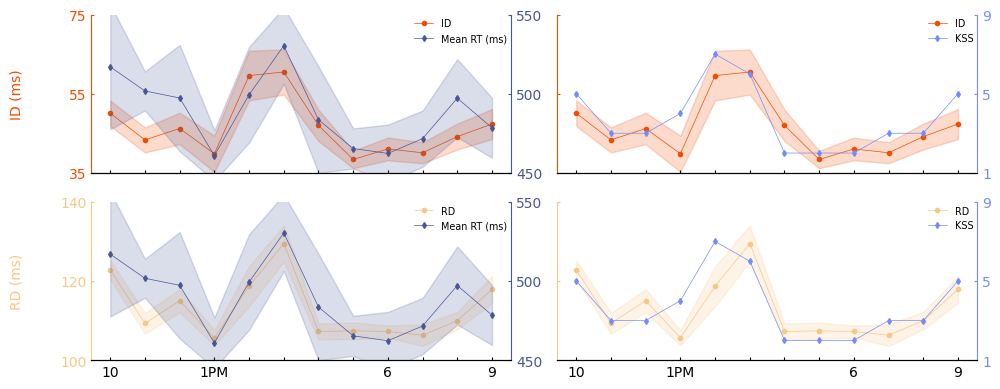

In [8]:
fig = drowsiness_blink_parameters_visualization(
    drowsiness_blink_parameters_df,
    5,
    ["closed_time", "reopening_time"],
    ["ID", "RD"],
    ["#F24C00", "#F9C784"],
    ["pvt", "kss_score"],
    ["Mean RT (ms)", "KSS"],
    ["#485696", "#758BFD"]
)

plt.tight_layout()

## blinks and cognitive workload

In [9]:
workload_blink_parameters_file = Path("../data/case-studies/workload_blink_parameters.csv")
workload_blink_parameters_df = pd.read_csv(workload_blink_parameters_file)
workload_blink_parameters_df.head()

,subject_id,condition,closing_time,closed_time,reopening_time,blink_time,open_time
0,1,baseline,85.551023,38.902044,114.436865,238.889933,382.268190
1,1,baseline,98.882914,38.870096,113.337994,251.091003,732.251883
2,1,baseline,81.125975,26.664972,85.554123,193.345070,830.029011
3,1,baseline,87.780952,34.473896,121.088028,243.342876,1384.499073
4,1,baseline,82.233906,27.770996,93.337059,203.341961,647.803068


In [10]:
def analyze_blink_parameters(df):
    """
    Analyze all blink parameters.
    
    Parameters:
    df: DataFrame with columns subject_id, condition, and blink parameters
    """
    # Parameters to analyze
    parameters = ['closing_time', 'closed_time', 'reopening_time', 'open_time', "blink_time"]
    
    results = {}
    
    for param in parameters:
        if param == 'open_time':
            # Remove missing values for open_time analysis
            param_df = df.dropna(subset=['open_time'])
        else:
            param_df = df
            
        print(f"\n=== Analysis of {param} ===")
        
        # 1. Calculate subject-level means
        subject_means = param_df.groupby(['subject_id', 'condition'])[param].mean().round(2)
        print("\nSubject Means:")
        print(subject_means.unstack())
        
        # 2. Perform RM ANOVA
        rm_anova = pg.rm_anova(data=param_df, dv=param, 
                              within='condition', subject='subject_id')
        print("\nRM ANOVA Results:")
        print(rm_anova)
        
        # 3. If ANOVA is significant, do post-hoc tests
        if rm_anova.iloc[0]['p-unc'] < 0.05:
            posthoc = pg.pairwise_tests(data=param_df, dv=param,
                                      within='condition', subject='subject_id',
                                      parametric=True,
                                      padjust='holm')
            print("\nPost-hoc Tests:")
            print(posthoc[['A', 'B', 'p-unc', 'p-corr', 'hedges']])
        
        # Store results
        results[param] = {
            'subject_means': subject_means,
            'rm_anova': rm_anova,
            'posthoc': posthoc if rm_anova.iloc[0]['p-unc'] < 0.05 else None
        }
    
    return results

In [11]:
results = analyze_blink_parameters(workload_blink_parameters_df)


=== Analysis of closing_time ===

Subject Means:
condition   baseline    easy    hard
subject_id                          
1              96.04   79.56   80.33
2             106.35  102.19  116.56
3             118.28   92.09   89.81
4              98.55   75.55   77.36
5              99.10   89.17   91.17
6              78.65   83.42   86.35
7              95.77  101.45   83.03
8              88.31   79.23   84.29
9              78.52   80.31   78.41
10             91.49   86.76   88.64

RM ANOVA Results:
      Source  ddof1  ddof2         F     p-unc       ng2       eps
0  condition      2     18  3.619511  0.047731  0.113334  0.839011

Post-hoc Tests:
          A     B     p-unc    p-corr    hedges
0  baseline  easy  0.045343  0.136029  0.725858
1  baseline  hard  0.084972  0.169943  0.618956
2      easy  hard  0.814710  0.814710 -0.057816

=== Analysis of closed_time ===

Subject Means:
condition   baseline   easy   hard
subject_id                        
1              40.88  31.

### tab 5: Blink Parameter Variations Across Visual Task Difficulty Levels

In [12]:
columns_to_see = ["reopening_time", "blink_time", "open_time"]
descriptions = ["Reopening Duration (RD)", "Blink Duration (BD)", "Open Duration (OD)"]

n_columns = len(columns_to_see)

# Create the table
table = PrettyTable()

# Set up the table structure with column names
table.field_names = ["", "RM ANOVA F(2, 18)", "Baseline vs. Easy", "Baseline vs. Hard", "Easy vs. Hard"]

for col in columns_to_see:
    rm_anova_result = results[col]['rm_anova']
    posthoc = results[col]['posthoc']

    # Get the F-value and p-value
    f_value = rm_anova_result.iloc[0]['F']
    p_value = rm_anova_result.iloc[0]['p-unc']
    f_string = f"{f_value:.2f} {p_value_to_significance(p_value)}"

    # Get the post-hoc p-values
    posthoc_values = posthoc["p-corr"].values.tolist()
    post_hoc_string = list(map(lambda x: f"{x:.3f} {p_value_to_significance(x)}", posthoc_values))

    # Add the row to the table
    table.add_row([descriptions[columns_to_see.index(col)], f_string] + post_hoc_string)


# Set alignment for each column
table.align[""] = "l"  # Left align first column
for column in table.field_names[1:]:
    table.align[column] = "c"  # Center align all other columns

title = "Table 5: Blink Parameter Variations Across Visual Task Difficulty Levels"
footnote = "Significance levels: **p<.01, *p<.05, † p<.1. Post-hoc analyses are Holm-Bonferroni corrected."

print(title)
print(table)
print(footnote)

Table 5: Blink Parameter Variations Across Visual Task Difficulty Levels
+-------------------------+-------------------+-------------------+-------------------+---------------+
|                         | RM ANOVA F(2, 18) | Baseline vs. Easy | Baseline vs. Hard | Easy vs. Hard |
+-------------------------+-------------------+-------------------+-------------------+---------------+
| Reopening Duration (RD) |     11.20 ***     |      0.006 **     |      0.029 *      |   0.547 n.s.  |
| Blink Duration (BD)     |      8.39 **      |      0.021 *      |      0.054 †      |   0.793 n.s.  |
| Open Duration (OD)      |      9.13 **      |      0.014 *      |      0.017 *      |   0.638 n.s.  |
+-------------------------+-------------------+-------------------+-------------------+---------------+
Significance levels: **p<.01, *p<.05, † p<.1. Post-hoc analyses are Holm-Bonferroni corrected.


### fig 15: Blink parameters across different workloads. Abbreviations are the same as in Tab. 5.

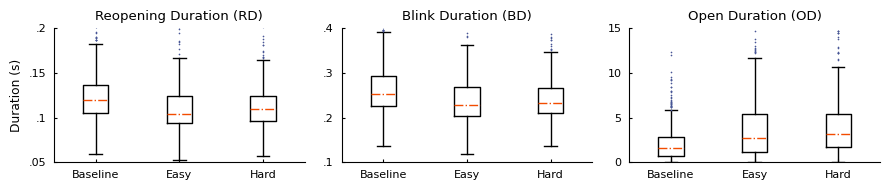

In [13]:
columns_to_see = ["reopening_time", "blink_time", "open_time"]
descriptions = ["Reopening Duration (RD)", "Blink Duration (BD)", "Open Duration (OD)"]

n_columns = len(columns_to_see)

with plt.style.context("seaborn-v0_8-paper"):
    fig, axes = plt.subplots(1, n_columns, figsize=(3 * n_columns, 2))

    y_lims = {
        "reopening_time": (50 / 1000, 200 / 1000),
        "blink_time": (100 / 1000, 400 / 1000),
        "open_time": (0, 15000 / 1000),
    }
    y_ticklabels = {
        "reopening_time": [".05", ".1", ".15", ".2"],
        "blink_time": [".1", ".2", ".3", ".4"],
        "open_time": ["0", "5", "10", "15"],
    }

    flierprops = dict(
        marker="o",
        markersize=1.2,
        linestyle="none",
        markerfacecolor="#485696",
        markeredgewidth=0.0,
    )
    medianprops = dict(linestyle="-.", linewidth=1, color="#F24C00")

    for ax_ind, (ax, column, description) in enumerate(
        zip(axes, columns_to_see, descriptions)
    ):
        all_conditions = workload_blink_parameters_df["condition"].unique()
        ax.boxplot(
            [
                workload_blink_parameters_df[
                    workload_blink_parameters_df["condition"] == condition
                ][column].dropna() / 1000
                for condition in all_conditions
            ],
            flierprops=flierprops,
            medianprops=medianprops,
        )

        ax.set_title(description)
        ax.set_xticklabels(["Baseline", "Easy", "Hard"])
        ax.set_xlabel("")
        if ax_ind == 0:
            ax.set_ylabel("Duration (s)")
        else:
            ax.set_ylabel("")
        ax.tick_params(axis="both", which="both", direction="in", length=2)

        if column in y_lims:
            ax.set_ylim(y_lims[column])

        if column in y_ticklabels:
            ax.set_yticks(
                list(map(lambda y_val: float(y_val), y_ticklabels[column])),
                labels=y_ticklabels[column],
            )

        ax.spines[["top", "right"]].set_visible(False)

    plt.tight_layout()
    plt.show()

## partial blink detections

> NOTE: You should have executed `scripts/evaluate.py` for the float-point model before running the following cells.

Instead of requring any additional dataset, the validatoin of partial blink detection can be done using the 20-subject dataset.

We plot the receiver-operating characteristic curve (ROC) and compute the area under the curve (AUC).

In [14]:
import sys
from tqdm import tqdm

script_dir = Path.cwd()
project_folder = script_dir.parent
if str(project_folder) not in sys.path:
    sys.path.insert(0, str(project_folder))

from src.core import project_files, blink_defs
from src.models.config import ExperimentConfig
from src.models.utils import prepare_exp_subsets, summarize_subjects_and_experiments
from src.evaluation import MetricEvaluator
from src.models.data import single_dataset_factory


2025-03-17 17:11:46.508902: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-17 17:11:46.530482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-17 17:11:46.530503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-17 17:11:46.531328: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 17:11:46.535596: I tensorflow/core/platform/cpu_feature_guar

In [15]:
# Replace with yours if you plan to use your own results
result_folder = Path("../data/reproducing-results/unet_20241203_214444") 

if not result_folder.exists():
    raise FileNotFoundError(f"Result folder not found: {result_folder}")
exp_config_file = result_folder / "config.json"
if not exp_config_file.exists():
    raise FileNotFoundError(f"Experiment configuration file not found: {exp_config_file}")

# Replace the processed dataset path if you have a different path
dataset_folder = Path("../data/processed-dataset")
if not dataset_folder.exists():
    raise FileNotFoundError(f"Dataset folder not found: {dataset_folder}")

In [ ]:
# recontructed openness curve should be available if you have executed the `scripts/evaluate.py`
curve_output_folder = result_folder / "curve_reconstruction_keras"
# blink phase labels should be available if you have executed the `scripts/label.py`
label_output_folder = result_folder / "labeling"

# validate the existence of the folders and files
if not curve_output_folder.exists():
    raise FileNotFoundError(f"Curve output folder not found: {curve_output_folder}. Have you run the evaluation script?")

all_curves = list(curve_output_folder.glob("*.npy"))
if len(all_curves) == 0:
    raise FileNotFoundError(f"No curve files found in {curve_output_folder}. Have the evaluation script run successfully?")

if not label_output_folder.exists():
    raise FileNotFoundError(f"Label output folder not found: {label_output_folder}. Have you run the evaluation script?")

all_labels = [f for f in label_output_folder.glob("*.npz") if "_tflite" not in f.stem]
if len(all_labels) == 0:
    raise FileNotFoundError(f"No label files found in {label_output_folder}. Have the evaluation script run successfully?")

In [ ]:
exp_config = ExperimentConfig.load(exp_config_file)
exp_config.data_folder = dataset_folder

exp_subset, val_exp_subset = prepare_exp_subsets(exp_config, verbose=False)
subject_exp_dict = summarize_subjects_and_experiments(exp_config.data_folder, exp_subset)

In [ ]:
def load_original_curve_and_non_blinking_masks(
        dataset_folder: Path,
        exp_name: str,
        dataset_config,
        crop: tuple[float, float]
) -> tuple[np.ndarray[float], np.ndarray[bool]]:
    """
    The same function as in the `scripts/evaluate.py` script to load the original curve and non-blinking masks.
    """
    sed = single_dataset_factory(data_folder=dataset_folder, experiment_name=exp_name, config=dataset_config)
    original_curve = sed._get_target_data(crop, dataset_config.curve_processing_protocol)

    crop_start, crop_end = sed.crop_to_start_end_index(crop)
    label_file_path = dataset_folder / exp_name / project_files.model_label_filename

    with np.load(label_file_path) as label_data:
        video = label_data["video"][crop_start:crop_end]

    video_non_blinking_mask = video == blink_defs.NON_BLINKING

    return original_curve, video_non_blinking_mask


In [ ]:
evaluator = MetricEvaluator(
    exp_config_path=exp_config_file,
    dataset_folder=dataset_folder,
    output_folder=result_folder,
    verbose=False
)

partial_blink_result = []
for subject, exp_list in tqdm(subject_exp_dict.items(), desc="Evaluating metrics"):
    for exp in exp_list:
        predicted_curve = np.load(curve_output_folder / f"{subject}_{exp}.npy")
        label_file = label_output_folder / f"{subject}_{exp}.npz"

        with np.load(label_file) as data:
            original_curve_labels = data["original"]
            predicted_curve_labels = data["pred"]

        original_curve, _ = load_original_curve_and_non_blinking_masks(
            dataset_folder=dataset_folder,
            exp_name=exp,
            dataset_config=evaluator.validation_dataset_config,
            crop=evaluator.training_config.get_crop_range("validation"),
        )

        results = evaluator.process(
            exp_name=exp,
            reconstructed_curve=predicted_curve,
            original_curve=original_curve,
            reconstructed_curve_labels=predicted_curve_labels,
            original_curve_labels=original_curve_labels,
            metrics=["partial_blinks"],
            partial_blink_thresholds=np.linspace(0, 1, 100),
        )

        partial_blink_result.extend(results['partial_blinks'].copy())

partial_blink_result_df = pd.DataFrame(partial_blink_result)

Evaluating metrics: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s]


In [ ]:
# Calculate TPR and FPR for each threshold
partial_blink_result_df["TPR"] = partial_blink_result_df["partial_true_positive"] / (
    partial_blink_result_df["partial_true_positive"]
    + partial_blink_result_df["partial_false_negative"]
)
partial_blink_result_df["FPR"] = partial_blink_result_df["partial_false_positive"] / (
    partial_blink_result_df["partial_false_positive"]
    + partial_blink_result_df["partial_true_negative"]
)

# Group by threshold to see overall performance at each threshold
summary = partial_blink_result_df.groupby("threshold")[["TPR", "FPR"]].mean()
summary = summary.dropna()
summary.head()

,TPR,FPR
threshold,,
0.010101,0.000000,0.000000
0.020202,0.000000,0.001546
0.030303,0.085127,0.009761
0.040404,0.363532,0.062761
0.050505,0.517771,0.105535


### fig 16: partial blink detection.

In [ ]:
from sklearn.metrics import auc

def plot_roc_curve(summary_df, space=1):
    # Sort by FPR for proper curve plotting and AUC calculation
    df_sorted = summary_df.sort_values('FPR')

    # Calculate AUC
    roc_auc = auc(df_sorted['FPR'], df_sorted['TPR'])

    # Get indices for every n_rows
    regular_indices = np.arange(0, len(df_sorted)-1, space)
    indices = np.append(regular_indices, len(df_sorted)-1)
    df_sorted = df_sorted.iloc[indices]
    
    # Create the plot
    plt.figure(figsize=(5, 5))
    
    # Plot ROC curve
    plt.plot(df_sorted['FPR'], df_sorted['TPR'], lw=1, label=f'ROC curve (AUC = {roc_auc:.2f})', c="#485696", ls="--")
    
    # Plot random guess line
    # plt.plot([0, 1], [0, 1], 'k--', label='Random guess')

    plt.annotate(f"AUC = {roc_auc:.2f}", xy=(0.5, 0.3), xycoords='axes fraction', ha='center', va='center', c="#020202")
    
    # Customize plot
    plt.xlim([0, 1.05])
    plt.ylim([0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    # plt.title('Receiver Operating Characteristic (ROC)')
    # plt.legend(loc='lower right')

    plt.xticks([0, 1], labels=["0", "1"])
    plt.yticks([1], labels=["1"])
    plt.grid(True, alpha=0.3)

    plt.tick_params(axis='both', which='both', direction='in', length=2)

    ax = plt.gca()

    ax.fill_between(df_sorted['FPR'], df_sorted['TPR'], color='#AEB8FE', alpha=0.5)
    
    ax.spines[["top", "right"]].set_visible(False)
    ax.xaxis.set_label_coords(0.5, -0.075)
    ax.yaxis.set_label_coords(-0., 0.5)

    plt.tight_layout()
    return plt.gcf(), roc_auc

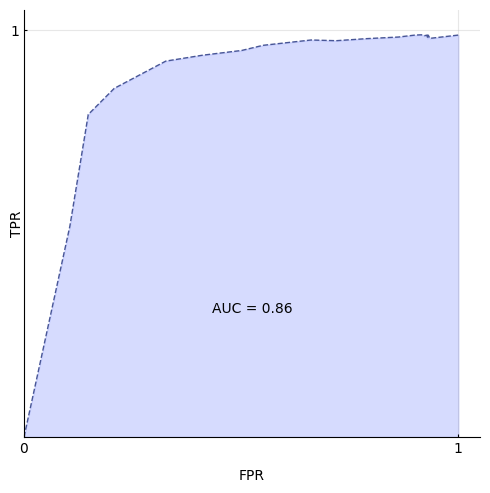

In [ ]:
fig, roc_auc = plot_roc_curve(summary.dropna().reset_index(), space=4)

In [ ]:
print(roc_auc)

0.8632584799940419
